# 2. Time Series Clustering

* Initially thought I would use 1 RNN based model for making predictions
    * But in order to do this I would have to onehot encode the meter_id's (as ordinal would apply a linear relation between id's which doesn't exist)
        * This would add an extra 3500 features and hence make the solution space sufficiently sparse that it is likely our model would give any sort of reasonable performance
        
* My next thought was that instead I could create a separate RNN based model for each of the meters
    * Issue is the time complexity of doing so: even if each model only takes 1 minute to run (of which it is likely they will take longer) that would be 2.4 days of continuous computation
        * And this would have to be repeated for hyperparameter tuning and changes to the model and methodology
            * Very impractical especially considering time constraint of the competition
            
* My plan is to compromise between the 2 by clustering similar time series patterns and having a separate model for making predictions for each of the similar patterns
    * May still have problems with the size of the onehot encoded variables
    * Will also have problem with missing variables as will soon see
    
* If this proves impractical will instead consider models which can better handle categorical values such as decision tree based methods
    * LGB
    * XGBoost
    * Etc.
    
# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
from tslearn.clustering import TimeSeriesKMeans
from yellowbrick.cluster import KElbowVisualizer

In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\psydm7\Anaconda3\envs\mle_tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\psydm7\Anaconda3\envs\mle_tf

# pd display options

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

#  Loading the data

In [3]:
df_energy = pd.read_pickle("../Data/Preprocessed_Data/consumption_daily_nan_interpolated.pkl")

In [ ]:
df_energy

# Looking at how many missing values we have

In [4]:
# how many nans do we have
nan_count = df_energy.drop("meter_id", axis=1).isnull().sum(axis = 0)
nan_count

2017-01-01    2983
2017-01-02    2980
2017-01-03    2980
2017-01-04    2980
2017-01-05    2980
2017-01-06    2980
2017-01-07    2980
2017-01-08    2980
2017-01-09    2980
2017-01-10    2980
2017-01-11    2980
2017-01-12    2980
2017-01-13    2980
2017-01-14    2980
2017-01-15    2980
2017-01-16    2980
2017-01-17    2980
2017-01-18    2980
2017-01-19    2980
2017-01-20    2980
2017-01-21    2980
2017-01-22    2980
2017-01-23    2980
2017-01-24    2980
2017-01-25    2980
2017-01-26    2980
2017-01-27    2979
2017-01-28    2979
2017-01-29    2979
2017-01-30    2979
2017-01-31    2979
2017-02-01    2716
2017-02-02    2713
2017-02-03    2712
2017-02-04    2712
2017-02-05    2712
2017-02-06    2712
2017-02-07    2712
2017-02-08    2712
2017-02-09    2712
2017-02-10    2712
2017-02-11    2711
2017-02-12    2711
2017-02-13    2711
2017-02-14    2711
2017-02-15    2711
2017-02-16    2711
2017-02-17    2711
2017-02-18    2711
2017-02-19    2711
2017-02-20    2711
2017-02-21    2711
2017-02-22  

<AxesSubplot:title={'center':'Missing values per day'}, xlabel='date', ylabel='number of missing values'>

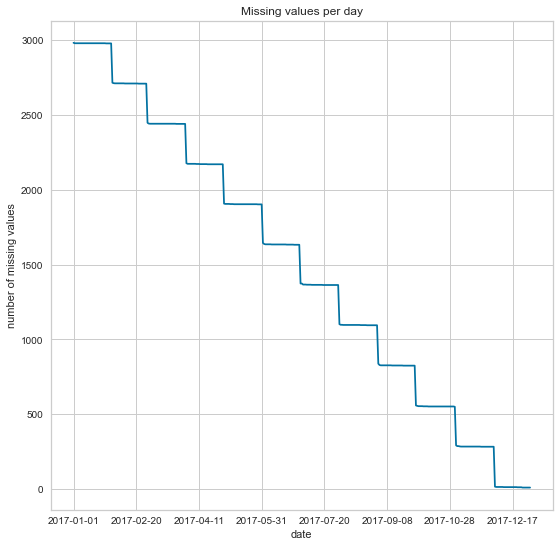

In [5]:
# plotting number of missing values
nan_count.plot(figsize=(9,9), title="Missing values per day", xlabel="date", ylabel="number of missing values")

#### Conclusions:
* We now know that the exists no single day where all meters have a reading
* The best we can get is a minimum of 11 missing values per day for the last 6 days of the year
    * This is likely as the battery in the meter has died.
* For the last 28 days we only have 21 different meters we are missing values for
* Before that it goes up exponentially making it impractical to use any more days than the last 28
    
* Plan is to:
    1. Create new dataframe of just the last 28 days
    2. Split that dataframe into 2 separate dataframes holding the rows which have don't have nan and the rows that do
    3. Cluster the dataframe without nans
    4. Impute the nan dataframe eg via ARIMA making predictions 
    5. Predict the cluster label for rows with newly imputed nans
    
* Questions are:
    * 1. just because they have similar patterns in december, are they likely to have similar patterns year round?
        * eg is this enough data to make a real conclusion on
    * 2. is it a good idea as the predicted values may not be accurate
    * 3. Obviously also will have to inspect and experiment with different amounts of clusters
    * 4. May also still have an issue with the onehot encoding if one cluster has too many assigned meters
        * so may be forced to use a different model
        * could maybe get around this with a keras embedding layer
        
# 1. Creating new dataframe of just the last 29 days 

In [6]:
# last 29 days have most reasonable amount of missing values
df_energy_last_29 = pd.concat([pd.DataFrame(df_energy["meter_id"]),df_energy.iloc[:,-29:]], axis=1)
df_energy_last_29

meter_id  2017-12-03  2017-12-04  \
0     0xa62b9f23553ff183f61e2bf943aab3d5983d02d7    3.517000    2.933000   
1     0x459c834d1f6cfb5b734b82aa9f5410fa97fb70da   18.057000   18.345000   
2     0x4a1ed36825360a058cec2bdd409fc2459e1ce54f   16.324000    8.211380   
3     0x5b76d3c0e0aefc6e0a8d1d031f96388a23263407   14.012000   23.073000   
4     0x943ebe39ef2be6ef807c42c5a647e27112ca5b0f   30.378000   27.224000   
5     0x263b7a6969c175823ea1fba2983668fa5f640ab4   20.607000   17.981000   
6     0xc8ef570cfdbc48c0555ba48ccb350403cf43cd79    1.332500    0.833820   
7     0x077eb7207315025bfd8dd65f5b81f8be612b3229   15.590000   23.401000   
8     0xaf8627889fff7ba6fa91bfae6b05636453d032f1    5.840000    6.519000   
9     0x3b7466451863d09c34673c4dfe45391d56e0cb23    4.212000    5.799000   
10    0xb1bd18b68569dd962497a9802036e536c10cc6a4         NaN    4.744000   
11    0xc0ae15ea749069eb610952a8b9dae0afaa4e7e3e    7.693000    6.911000   
12    0xdaaa7ff89654c1b4cf2cfc48f7e82f2789228b91    5.802000    5.665000   
13    0x2a7b4bac42d193820c172ad07f41aac9de94bb62   10.894000    8.554000   
14    0x761df95c32b60b85eb661847be7cbab29bd02987    4.211500    4.571000   
15    0xf51f50b28734e81f32cdcc19a5ce0fb71fa5ef33   16.515000   17.884000   
16    0xb64ea6716e4721372c7d27c5ee60d374b26d5f89   13.220000    9.386500   
17    0x7aed4c56e5c777de630d121d30135b2e89c21645   42.778000   29.476000   
18    0x232fca03d6664d7ee076957b97c9ff15550c7f13   21.110000   15.869000   
19    0x06451f569f4d58af40f62c5b7c0a8599343c399e    2.612000    3.341000   
20    0xcf3f08e4a68224b8f0b320cb1a881f5284c3d78a    9.159000    9.573000   
21    0xf889926d1bbe52b6083cd17407003672a5ea452b   39.289000   43.179000   
22    0x30de40a4dbf2b8fed72af70b7299bb809207891c    4.555000    4.413000   
23    0xd9810e8107564b13dfde7610aa2bd73efc34c042    7.260000    3.997000   
24    0x2d619210b2deb7415f933a31eedb72e0c26c354b   16.666000    9.871000   
25    0x906f468ff0db2f8253975c416d5deedaf656192e    9.047500   13.638500   
26    0x1892e45218e98db1b685d2388743bc86274cd9b1   18.224000   10.215500   
27    0x59cba91f66889884bf5baf58fd18ba99fb77438d   15.056000   12.993000   
28    0xe7b553dd4db76e486330f49768c8fa0665e319e4   17.862000   11.464000   
29    0xc37066d2433611d8d75fd59b1724f6f9d07f0511   13.276000    8.685000   
30    0x2baf80c270849ec1fd8222f47129916b80a7d40c    6.542000    5.256000   
31    0xaf7094b81b9737fe263b4887329b9ffec288fd89    6.467500    7.035500   
32    0x75674900251c688b097c1c9f9f13ba36d6837381   12.853000   12.018000   
33    0x9ba6d56cf9b5cfa828b54ab6590bdc6a98ea2f42   10.949000    9.930000   
34    0x83f4fc39e9254f3a408a7b5df883b7fb5b771fdf    9.253000    8.803000   
35    0xf044f491d9067bf9c3295757b39921288ca6ba22   10.544000    9.838000   
36    0x90332bac5691acf18f59d6ab67a13a4a5f43c5c4   33.765000   37.856000   
37    0x41fe86582f0d54ac06b4b4879cb3fafb562a2551    3.787000    3.309000   
38    0xd949e420fced0015a492c9f14f7bf9cbf7e23030    3.818000    4.135000   
39    0x16a7880544b9b7d9a69afc30176dda1d63a3db21    4.634000    6.075000   
40    0x2fdeb0e07379cb828c454fba889b7bc06d45cff9    5.731000    6.888000   
41    0x79ed1cb181a815b7f9d95b40dc4da2fd1327ca25    7.300000    8.917000   
42    0x103ff56484349e910b407b7d0dbf2f3b99cab382    0.986000    1.130000   
43    0xe88877387eb740ddee69552c077c313e857b927c   10.090000   13.488000   
44    0x11f7baeffef2df2a63e77fa716194442b2dd7054    3.879000    3.751000   
45    0xe6f078a104e93ebbe5699e0be5469f79334c8f49    6.104000    7.589000   
46    0x9f91391e2af8b6079534dd784bbeca1d47729295    7.825000    7.435000   
47    0xbc41dd443f341470749c3b45d054251db8bb7034   15.718000    9.594000   
48    0xe3a7bc1bf7a16a18347aa6c38f4e2eb031db14a4    7.372000    5.796000   
49    0xf3f92cd3e987c9e093fca5845508eaed2eefa190    5.588000    6.450000   
50    0x9a2c8f1fb05b111da9be701fad29cb715ba54419    6.598000    8.478000   
51    0x244d89eb4e1474e38311bc7cd37d3c1288aeb415   14.182000   13.458000   
52    0x6d90

In [ ]:
# checking the number of missing values
df_energy_last_29.isnull().sum(axis = 0)

# 2. Splitting dataset based on missing columns
## no nans

In [7]:
#getting dataframe with no nans
df_energy_29_no_nan = df_energy_last_29.dropna(axis=0)

In [ ]:
# inspecting no nans
df_energy_29_no_nan

In [ ]:
# checking the number of missing values (should be 0)
df_energy_29_no_nan.isnull().sum(axis = 0)

## with nans

In [ ]:
# Getting dataframe with just nans
df_energy_29_with_nan = df_energy_last_29[~df_energy_last_29.isin(df_energy_29_no_nan)].dropna(how="all")

In [ ]:
# inspecting nans
df_energy_29_with_nan

In [ ]:
# checking the number of missing values
df_energy_29_with_nan.isnull().sum(axis = 0)

In [ ]:
# looking at a plot of it
df_energy_29_with_nan.drop("meter_id", axis=1).T.plot()

# 3. Clustering the dataframe with no nans
## Getting optimal euclidean K value via elbow
Only using normal euclidean as dba and soft-dtw would take too long 

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html


clusterer = TimeSeriesKMeans()
visualizer = KElbowVisualizer(clusterer, k=(1,75))

visualizer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))
plt.title("TimeSeries kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/_elbow.png")
visualizer.show()

In [ ]:
# k value (how many clusters)
k = 11

## Clustering via euclidean kmeans

In [ ]:
#fitting the euclidean kmeans
clusterer = TimeSeriesKMeans(n_clusters=k)
clusterer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_euc = clusterer.predict(df_energy_29_no_nan.drop("meter_id",axis=1))
labels_euc


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_no_nan_labels = df_energy_29_no_nan
df_energy_29_no_nan_labels["labels"]=labels_euc
df_energy_29_no_nan_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/euclidean/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/euclidean/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_euc)):
    plt.figure(figsize=(10,5))
    plt.title("Euclidean centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_no_nan_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/euclidean/{k}/cluster_{i}")
    plt.show()
    plt.close()

## Clustering the data via dba kmeans
### Using the elbow method to find the best value for k for dba

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html


clusterer = TimeSeriesKMeans(n_init=2, metric="dtw", max_iter_barycenter=10)
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))
plt.title("DBA kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/dba/_elbow.png")
visualizer.show()

In [9]:
# k value (how many clusters)
k =11

### Running DBA kMeans to cluster the data using the optimal k elbow

In [ ]:
#fitting the dba kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, n_init=2, metric="dtw", max_iter_barycenter=10)
clusterer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_dba = clusterer.predict(df_energy_29_no_nan.drop("meter_id",axis=1))
labels_dba


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_no_nan_labels = df_energy_29_no_nan
df_energy_29_no_nan_labels["labels"]=labels_dba
df_energy_29_no_nan_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/dba/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/dba/{k}/")


# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dba)):
    plt.figure(figsize=(10,5))
    plt.title("DBA centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_no_nan_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid", ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/dba/{k}/cluster_{i}")
    plt.show()
    plt.close()

## Clustering the data via soft dtw kmeans
### Finding elbow of soft-dtw

In [ ]:
# elbow method for getting best value for k
# https://www.scikit-yb.org/en/latest/api/cluster/elbow.html


clusterer = TimeSeriesKMeans(metric="softdtw", metric_params={"gamma":0.01})
visualizer = KElbowVisualizer(clusterer, k=(1,25))

visualizer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))
plt.title("soft-dtw kMeans Elbow")
plt.savefig("../EDA/plots/consumption/Clustering/soft-dtw/_elbow.png")
visualizer.show()

In [ ]:
# k value (how many clusters)
k = 8

### Running soft-dtw kmeans on the optimal k value

In [ ]:
#fitting the soft-dtw kmeans
clusterer = TimeSeriesKMeans(n_clusters=k, metric="softdtw", metric_params={"gamma":0.01})
clusterer.fit(df_energy_29_no_nan.drop("meter_id", axis=1))

In [ ]:
# getting the centroids
centroids = clusterer.cluster_centers_

In [ ]:
#predicting which meters belong to which cluster
labels_dtw = clusterer.predict(df_energy_29_no_nan.drop("meter_id",axis=1))
labels_dtw


In [ ]:
#adding the labels to the dataframe for ease of plotting
df_energy_29_no_nan_labels = df_energy_29_no_nan
df_energy_29_no_nan_labels["labels"]=labels_dtw
df_energy_29_no_nan_labels

In [ ]:
if not os.path.exists(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/"):
    os.makedirs(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/")

# plotting the assigned points ontop of the centroids
for i in tqdm(np.unique(labels_dtw)):
    plt.figure(figsize=(10,5))
    plt.title("soft-dtw centroid "+str(i+1)+" of "+str(k)+" assignments")
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    for j in tqdm(range(len(df_energy_29_no_nan_labels.drop("meter_id",axis=1))), leave=False):
        if(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_29_no_nan.drop("meter_id",axis=1).iloc[j].T, color="blue",lw=0.5, label="assigned")
    plt.plot(centroids[i], color="red",lw=3, label="centroid",ls="dashed")
    plt.savefig(f"../EDA/plots/consumption/clustering/soft-dtw/{k}/cluster_{i}")
    plt.show()
    plt.close()

# TODO : 

* Once elbows are finished
    * rerun code for the differenet kmeans with the optimal k value for each
    
* add labels to the entire dataset
* simply plot each of the clusters of the one with the best distribution error with all the missing nan ones on top then assign them to the one they best fit

# Conclusions:

* DBA gave the best performance out of the 3 tested time series suited kmeans methods
    * Backs up findings from here https://blog.acolyer.org/2016/05/13/dynamic-time-warping-averaging-of-time-series-allows-faster-and-more-accurate-classification/
    
* Hence will use the DBA found classifications

# Classifying the missing nans

In [ ]:
# reconstructing dataset with the dba based labels
df_energy_29_no_nan_labels = df_energy_29_no_nan
df_energy_29_no_nan_labels["labels"]=labels_dba
df_energy_29_no_nan_labels

In [ ]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_no_nan_labels = pd.merge(df_energy, df_energy_29_no_nan_labels[{"meter_id","labels"}], on="meter_id",how="inner")
df_energy_no_nan_labels

In [ ]:
# joining based on meter_id to assign labels to the original dataset (with all meter readings)
df_energy_with_nan = pd.merge(df_energy, df_energy_29_with_nan["meter_id"], on="meter_id",how="inner")
df_energy_with_nan

# Assigning the missing nans to a label
* Going to do this by simply plotting them on top of the clusters of each label and then assigning to the one they fit best

In [ ]:
# plotting the unassigned labels on top of each label to see which they best fit
for i in tqdm(np.unique(labels_dba)):
    plt.figure(figsize=(15,15))
    plt.title("centroid "+str(i+1)+" of "+str(k))
    plt.xlabel("Date")
    plt.ylabel("Energy usage")
    plt.locator_params(axis='x', nbins=10)
    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_no_nan_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_no_nan_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_no_nan_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color="blue",lw=0.5)
    
    #plotting the one with missing nans
    for j in tqdm(range(len(df_energy_with_nan.drop("meter_id",axis=1))), leave=False):
        plt.plot(df_energy_with_nan.drop("meter_id",axis=1).fillna(0).iloc[j].T, label=str(df_energy_29_no_nan["meter_id"].iloc[j]),lw=1)
    plt.legend(loc="upper left")
    plt.show()
    plt.close()

In [ ]:
# plotting all the assigned data on top of each other

colours = ["red","blue","green","black","orange","purple","brown","grey","pink","cyan","magenta","olive"]

plt.figure(figsize=(15,15))
plt.title("centroid "+str(i+1)+" of "+str(k))
plt.xlabel("Date")
plt.ylabel("Energy usage")
plt.locator_params(axis='x', nbins=10)

for i in tqdm(np.unique(labels_dba)):

    
    #plotting the one with no missing nans in december
    for j in tqdm(range(len(df_energy_no_nan_labels.drop("meter_id",axis=1).drop("labels",axis=1))), leave=False):
        if(df_energy_no_nan_labels.drop("meter_id",axis=1).iloc[j].labels==i):
            plt.plot(df_energy_no_nan_labels.drop("meter_id",axis=1).drop("labels",axis=1).fillna(0).iloc[j].T, color=colours[i],lw=0.5)

plt.show()
plt.close()

# Conclusions
* 
##### After experimenting with various K values on 3 different time series suited adaptions of KMeans it has become clear the data is not suitable for clustering.
    * small K's give issue that too many are values in each cluster so we still have the issue of one hot encoding
    * large K's gives issue that too many models need to be trained so we still have the issue of time complexity
    * Additionally even with large K's it seems there are only a few 'main' clusters which have lots and lots of assigned meters and the majority of clusters only having < 10, some even only containing a single point (clear sign of overfitting)
    
    * Additionally can see that in each cluster there is a great range of patterns within it; even with larger values of K. 
        * Hence it is unsuitable to really say these meters have similar enough patterns to group together